### drift testing

### one subject for testing

In [35]:
###
import sys
print(sys.path)
sys.path.append("C:/Users/jz421/Desktop/GlobalLocal/IEEG_Pipelines/") #need to do this cuz otherwise ieeg isn't added to path...

from ieeg.navigate import channel_outlier_marker, trial_ieeg, crop_empty_data, \
    outliers_to_nan
from ieeg.io import raw_from_layout, get_data
from ieeg.timefreq.utils import crop_pad
from ieeg.timefreq import gamma
from ieeg.calc.scaling import rescale
import mne
import os
import numpy as np
from ieeg.calc.reshape import make_data_same
from ieeg.calc.stats import time_perm_cluster

from misc_functions import calculate_RTs, save_channels_to_file, save_sig_chans
import matplotlib.pyplot as plt


def get_baseline(inst: mne.io.BaseRaw, base_times: tuple[float, float]):
    inst = inst.copy()
    inst.load_data()
    ch_type = inst.get_channel_types(only_data_chs=True)[0]
    inst.set_eeg_reference(ref_channels="average", ch_type=ch_type)

    adjusted_base_times = [base_times[0] - 0.5, base_times[1] + 0.5]
    trials = trial_ieeg(inst, "experimentStart", adjusted_base_times,
                        preload=True)
    # outliers_to_nan(trials, outliers=10)
    HG_base = gamma.extract(trials, copy=False, n_jobs=1)
    crop_pad(HG_base, "0.5s")
    del inst
    return HG_base


def plot_HG_and_stats(sub, task, output_name, event=None, times=(-1, 1.5),
                      base_times=(-0.5, 0), LAB_root=None, channels=None,
                      full_trial_base=False):
    """
    Plot high gamma (HG) and statistics for a given subject and task using specified event.

    Parameters:
    - sub (str): The subject identifier.
    - task (str): The task identifier.
    - output_name (str): The name for the output files.
    - event (str, optional): Event name to process. Defaults to None.
    - times (tuple, optional): A tuple indicating the start and end times for processing. Defaults to (-1, 1.5).
    - base_times (tuple, optional): A tuple indicating the start and end base times for processing. Defaults to (-0.5, 0).
    - LAB_root (str, optional): The root directory for the lab. Will be determined based on OS if not provided. Defaults to None.
    - channels (list of strings, optional): The channels to plot and get stats for. Default is all channels.
    - full_trial_base (boolean): Whether to use the full trial as the baseline period. Default is False.
    This function will process the provided event for a given subject and task.
    High gamma (HG) will be computed, and statistics will be calculated and plotted.
    The results will be saved to output files.
    """
    pass


sub = 'D0057'
task = 'GlobalLocal'
output_name = "stimulusCongruent_experimentStartBaseManualTimes"
events = ["Stimulus"]
times = (-1,1.5)
base_times = (1, 101)
LAB_root = None
channels = None
full_trial_base = False

if LAB_root is None:
    HOME = os.path.expanduser("~")
    if os.name == 'nt':  # windows
        LAB_root = os.path.join(HOME, "Box", "CoganLab")
    else:  # mac
        LAB_root = os.path.join(HOME, "Library", "CloudStorage", "Box-Box",
                                "CoganLab")

layout = get_data(task, root=LAB_root)
filt = raw_from_layout(layout.derivatives['derivatives/clean'], subject=sub,
                       extension='.edf', desc='clean', preload=False)
save_dir = os.path.join(layout.root, 'derivatives', 'freqFilt', 'figs', sub)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

###

good = crop_empty_data(filt)
# %%

print(f"good channels before dropping bads: {len(good.ch_names)}")
print(f"filt channels before dropping bads: {len(filt.ch_names)}")

good.info['bads'] = channel_outlier_marker(good, 3, 2)
print("Bad channels in 'good':", good.info['bads'])

filt.drop_channels(good.info['bads'])  # this has to come first cuz if you drop from good first, then good.info['bads'] is just empty
good.drop_channels(good.info['bads'])

print("Bad channels in 'good' after dropping once:", good.info['bads'])

print(f"good channels after dropping bads: {len(good.ch_names)}")
print(f"filt channels after dropping bads: {len(filt.ch_names)}")

HG_base = get_baseline(filt, base_times)
good.load_data()

# If channels is None, use all channels
if channels is None:
    channels = good.ch_names
else:
    # Validate the provided channels
    invalid_channels = [ch for ch in channels if ch not in good.ch_names]
    if invalid_channels:
        raise ValueError(
            f"The following channels are not valid: {invalid_channels}")

    # Use only the specified channels
    good.pick_channels(channels)

ch_type = filt.get_channel_types(only_data_chs=True)[0]
good.set_eeg_reference(ref_channels="average", ch_type=ch_type)

all_epochs_list = []

for event in events:
# Epoching and HG extraction for each specified event. Then concatenate all trials epochs objects together (do Stimulus/c25 and Stimulus/c75 for example, and combine to get all congruent trials)
    times_adj = [times[0] - 0.5, times[1] + 0.5]
    trials = trial_ieeg(good, event, times_adj, preload=True,
                        reject_by_annotation=False)
    all_epochs_list.append(trials)

# Concatenate all trials
all_trials = mne.concatenate_epochs(all_epochs_list)

outliers_to_nan(all_trials, outliers=10)
HG_ev1 = gamma.extract(all_trials, copy=False, n_jobs=1)


HG_ev1_rescaled = rescale(HG_ev1, HG_base, copy=True, mode='zscore')

HG_base.decimate(2)
HG_ev1.decimate(2)
RTs, skipped = calculate_RTs(good)
avg_RT = np.median(RTs)

HG_ev1_evoke = HG_ev1.average(method=lambda x: np.nanmean(x, axis=0)) #axis=0 should be set for actually running this, the axis=2 is just for drift testing.
HG_ev1_evoke_rescaled = HG_ev1_rescaled.average(method=lambda x: np.nanmean(x, axis=0))

if event == "Stimulus":
    print('plotting stimulus')
    fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1)) #this line is not finishing...
    print('plotted')
    # for ax in fig.axes:
    #     ax.axvline(x=avg_RT, color='r', linestyle='--')
    print('about to save')
    fig.savefig(save_dir + '_HG_ev1_Stimulus_zscore.png')
    print('saved')
else:
    print('about to plot if not stimulus')
    fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1))
    print('plotted non stimulus')
    fig.savefig(save_dir + f'_HG_ev1_{output_name}_zscore.png')

###
print(f"Shape of HG_ev1._data: {HG_ev1._data.shape}")
print(f"Shape of HG_base._data: {HG_base._data.shape}")

sig1 = HG_ev1._data
sig2 = HG_base._data
sig2 = make_data_same(sig2, sig1.shape)
print(f"Shape of sig1: {sig1.shape}")
print(f"Shape of sig2: {sig2.shape}")

mat = time_perm_cluster(sig1, sig2, 0.05, n_jobs=6, ignore_adjacency=1)
fig = plt.figure()
plt.imshow(mat, aspect='auto')
fig.savefig(save_dir + f'_{output_name}_stats.png', dpi=300)

channels = good.ch_names

#save channels with their indices 
save_channels_to_file(channels, sub, task, save_dir)

# save significant channels to a json
save_sig_chans(f'{output_name}', mat, channels, sub, save_dir)


['c:\\Users\\jz421\\Desktop\\GlobalLocal', 'C:\\Users\\jz421\\Desktop\\GlobalLocal\\IEEG_Pipelines', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\python311.zip', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\DLLs', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg', '', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32\\lib', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\Pythonwin', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages\\win32', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\L

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 226 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 178
filt channels before dropping bads: 178
outlier round 1 channels: ['RAMT8']


KeyboardInterrupt: 

In [34]:
filt[:,slice(0, 4000)]

(array([[ 1.00101581e-05,  2.57128361e-06,  3.96607257e-06, ...,
         -7.73966170e-05, -7.27473205e-05, -6.62383053e-05],
        [ 1.55893139e-05,  4.89593188e-06,  4.89593188e-06, ...,
         -2.34647771e-05, -1.88154805e-05, -1.18415357e-05],
        [-7.36771798e-05, -8.48354915e-05, -8.34407025e-05, ...,
         -8.48354915e-05, -8.06511246e-05, -7.32122501e-05],
        ...,
        [ 1.55893139e-05,  4.89593188e-06, -3.00787225e-06, ...,
          1.23348064e-05,  1.51243843e-05,  1.97736808e-05],
        [-2.34647771e-05, -3.64828074e-05, -4.81060488e-05, ...,
         -1.83505509e-05, -1.18415357e-05, -9.98181707e-06],
        [ 1.37295953e-05,  1.64142430e-06, -9.98181707e-06, ...,
          1.93087512e-05,  3.37215705e-05,  2.90722739e-05]]),
 array([0.00000000e+00, 4.88281250e-04, 9.76562500e-04, ...,
        1.95166016e+00, 1.95214844e+00, 1.95263672e+00]))

### loop over all subjects

In [29]:
# crop_pad(HG_ev1, "0.5s")
HG_ev1.tmax

0.0

['c:\\Users\\jz421\\Desktop\\GlobalLocal', 'C:\\Users\\jz421\\Desktop\\GlobalLocal\\IEEG_Pipelines', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\python311.zip', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\DLLs', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg', '', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32\\lib', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\Pythonwin', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages\\win32', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\L

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 226 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 178
filt channels before dropping bads: 178
outlier round 1 channels: ['RAMT8']
outlier round 2 channels: ['RAMT8', 'RPI16']
outlier round 2 channels: ['RAMT8', 'RPI16', 'LAMT12']
Bad channels in 'good': ['RAMT8', 'RPI16', 'LAMT12']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 175
filt channels after dropping bads: 175
Reading 0 ... 8243199  =      0.000 ...  4025.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus

100%|██████████| 1/1 [00:59<00:00, 59.01s/it]


Reading 0 ... 5983997  =      0.000 ...  2921.874 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
51 matching events foun

C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\3260712279.py:134: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
219 matching events found
No baseline correction applied


100%|██████████| 219/219 [04:54<00:00,  1.34s/it]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\3260712279.py:141: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\3260712279.py:142: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
about to plot if not stimulus


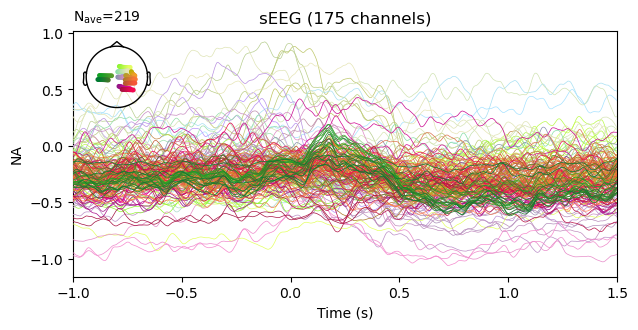

plotted non stimulus
Shape of HG_ev1._data: (219, 175, 2561)
Shape of HG_base._data: (1, 175, 102401)
Shape of sig1: (219, 175, 2561)
Shape of sig2: (39, 175, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   28.6s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   28.6s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   29.0s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   29.4s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   29.5s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   29.5s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:   53.9s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:   54.7s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:   54.9s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:   55.1s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:   55.1s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:   55.2s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  1.3min
[Parallel(

Saved channel names and indices to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0057\channels_D0057_GlobalLocal.txt
Saved significant channels for subject D0057 and mask responseIncongruent_experimentStartBase1secTo101Sec to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0057\sig_chans_D0057_responseIncongruent_experimentStartBase1secTo101Sec.json
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 226 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 184
filt channels before dropping bads: 184
outlier round 1 channels: ['LMPF15']
outlier round 2 channels: ['LMPF15', 'LASP3']
outlier round 2 channels: ['LMPF15', 'LASP3', 'LASP5']
outlier round 2 channels: ['LMPF15', 'LASP3', 'LASP5', 'LASP6']
outlier round 2 channels: ['LMPF15', 'LASP3', 'LASP5', 'LASP6', 'LMPT2']
outlier round 2 channels: ['LMPF15', 'LASP3', 'LASP5', 'LASP6', 'LMPT2', 'LPT16']
Bad channels in 'good': ['LMPF15', 'LASP3', 'LASP5', 'LASP6', 'LMPT2', 'LPT16']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 178
filt channels after dropping bads: 178
Reading 0 ... 8769535  =      0.000 ...  4282.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n25', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', '

100%|██████████| 1/1 [01:02<00:00, 62.44s/it]


Reading 0 ... 6582517  =      0.000 ...  3214.120 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n25', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', 'Response/i25/n75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/n25', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n25', 'Stimulus/i25/n75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
55 

C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\3260712279.py:134: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
223 matching events found
No baseline correction applied


100%|██████████| 223/223 [05:02<00:00,  1.35s/it]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\3260712279.py:141: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\3260712279.py:142: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
about to plot if not stimulus


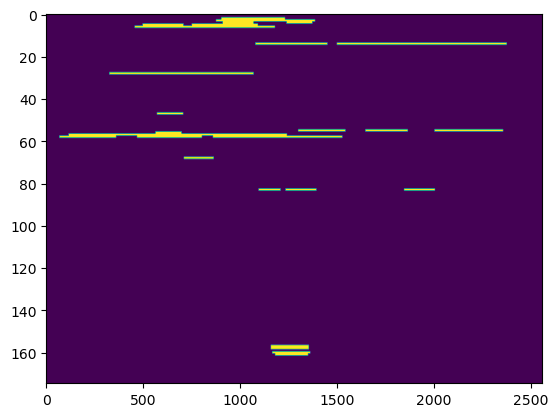

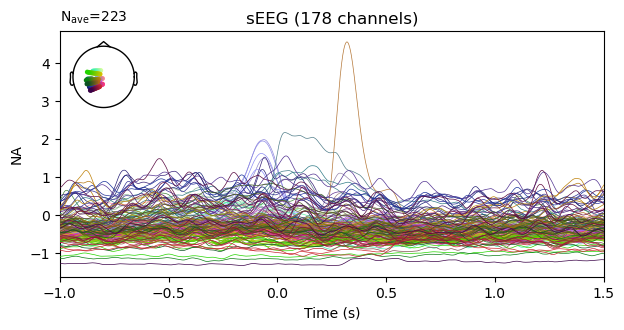

plotted non stimulus
Shape of HG_ev1._data: (223, 178, 2561)
Shape of HG_base._data: (1, 178, 102401)
Shape of sig1: (223, 178, 2561)
Shape of sig2: (39, 178, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   29.2s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   29.4s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   29.6s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   29.6s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   29.8s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   29.8s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:   56.5s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:   56.5s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:   56.7s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:   57.0s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:   57.1s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:   57.1s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  1.4min
[Parallel(

Saved channel names and indices to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0059\channels_D0059_GlobalLocal.txt
Saved significant channels for subject D0059 and mask responseIncongruent_experimentStartBase1secTo101Sec to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0059\sig_chans_D0059_responseIncongruent_experimentStartBase1secTo101Sec.json
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (241) does not match the number of channels in the raw data file (240). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 227 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (241) does not match the number of channels in the raw data file (240). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (241) does not match the number of channels in the raw data file (240). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 220 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (241) does not match the number of channels in the raw data file (240). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 240
filt channels before dropping bads: 240
outlier round 1 channels: ['LOF16']
outlier round 1 channels: ['LOF16', 'RMMT14']
outlier round 2 channels: ['LOF16', 'RMMT14', 'LOF10']
outlier round 2 channels: ['LOF16', 'RMMT14', 'LOF10', 'LOF14']
outlier round 2 channels: ['LOF16', 'RMMT14', 'LOF10', 'LOF14', 'ROF2']
outlier round 2 channels: ['LOF16', 'RMMT14', 'LOF10', 'LOF14', 'ROF2', 'RAMF4']
Bad channels in 'good': ['LOF16', 'RMMT14', 'LOF10', 'LOF14', 'ROF2', 'RAMF4']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 234
filt channels after dropping bads: 234
Reading 0 ... 4386815  =      0.000 ...  2142.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Resp

100%|██████████| 1/1 [01:16<00:00, 76.25s/it]


Reading 0 ... 3925799  =      0.000 ...  1916.894 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/n75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n25', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
56 

C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\3260712279.py:134: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
217 matching events found
No baseline correction applied


100%|██████████| 217/217 [06:23<00:00,  1.77s/it]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\3260712279.py:141: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\3260712279.py:142: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
about to plot if not stimulus


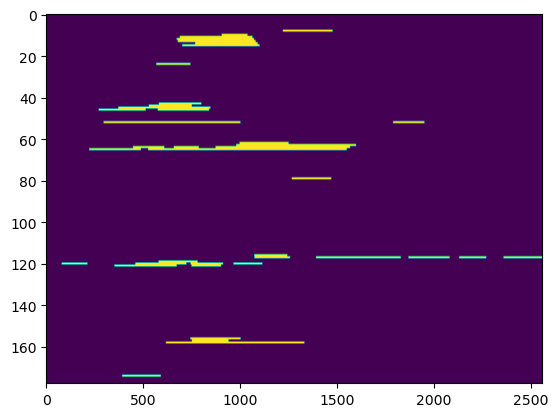

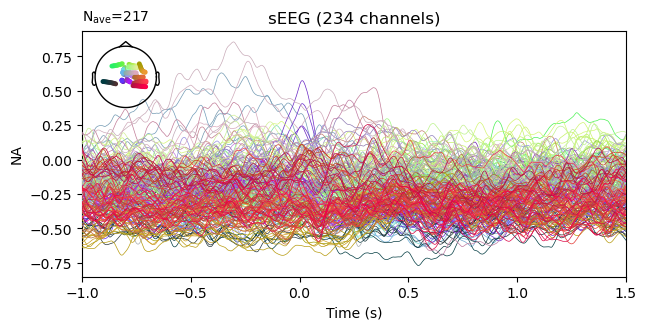

plotted non stimulus
Shape of HG_ev1._data: (217, 234, 2561)
Shape of HG_base._data: (1, 234, 102401)
Shape of sig1: (217, 234, 2561)
Shape of sig2: (39, 234, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   28.5s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   28.6s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   28.8s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   28.9s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   28.9s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   29.4s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:   54.2s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:   55.0s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:   55.2s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:   55.4s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:   55.5s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:   56.1s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  1.4min
[Parallel(

Saved channel names and indices to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0063\channels_D0063_GlobalLocal.txt
Saved significant channels for subject D0063 and mask responseIncongruent_experimentStartBase1secTo101Sec to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0063\sig_chans_D0063_responseIncongruent_experimentStartBase1secTo101Sec.json
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (221) does not match the number of channels in the raw data file (220). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 217 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (221) does not match the number of channels in the raw data file (220). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 225 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (221) does not match the number of channels in the raw data file (220). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 222 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (221) does not match the number of channels in the raw data file (220). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 220
filt channels before dropping bads: 220
outlier round 1 channels: ['RPIF3']
outlier round 1 channels: ['RPIF3', 'RAIO9']
outlier round 2 channels: ['RPIF3', 'RAIO9', 'RAMT15']
outlier round 2 channels: ['RPIF3', 'RAIO9', 'RAMT15', 'RMMT8']
Bad channels in 'good': ['RPIF3', 'RAIO9', 'RAMT15', 'RMMT8']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 216
filt channels after dropping bads: 216
Reading 0 ... 6350847  =      0.000 ...  3101.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s2

100%|██████████| 1/1 [01:11<00:00, 71.50s/it]


Reading 0 ... 5705315  =      0.000 ...  2785.798 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
51 

C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\3260712279.py:134: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
205 matching events found
No baseline correction applied


100%|██████████| 205/205 [05:28<00:00,  1.60s/it]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\3260712279.py:141: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\3260712279.py:142: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
about to plot if not stimulus


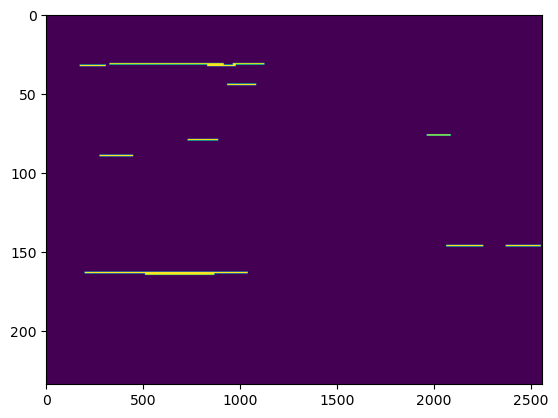

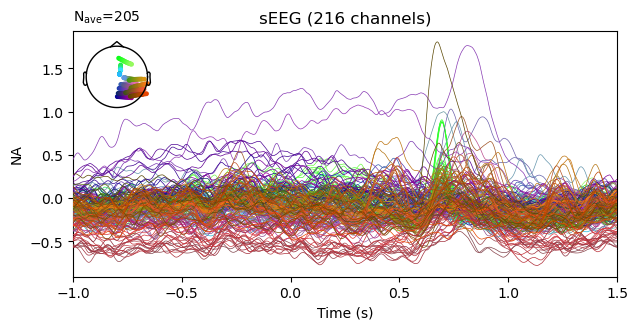

plotted non stimulus
Shape of HG_ev1._data: (205, 216, 2561)
Shape of HG_base._data: (1, 216, 102401)
Shape of sig1: (205, 216, 2561)
Shape of sig2: (39, 216, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   27.2s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   27.2s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   27.5s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   27.5s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   27.7s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   27.7s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:   50.8s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:   51.3s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:   51.6s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:   51.6s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:   51.7s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:   51.8s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  1.3min
[Parallel(

Saved channel names and indices to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0065\channels_D0065_GlobalLocal.txt
Saved significant channels for subject D0065 and mask responseIncongruent_experimentStartBase1secTo101Sec to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0065\sig_chans_D0065_responseIncongruent_experimentStartBase1secTo101Sec.json
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (133) does not match the number of channels in the raw data file (132). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 224 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (133) does not match the number of channels in the raw data file (132). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 224 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (133) does not match the number of channels in the raw data file (132). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 214 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (133) does not match the number of channels in the raw data file (132). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 132
filt channels before dropping bads: 132
outlier round 1 channels: ['LTMS11']
outlier round 2 channels: ['LTMS11', 'LTAS9']
Bad channels in 'good': ['LTMS11', 'LTAS9']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 130
filt channels after dropping bads: 130
Reading 0 ... 5701631  =      0.000 ...  2784.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c

100%|██████████| 1/1 [00:41<00:00, 41.65s/it]


Reading 0 ... 5221780  =      0.000 ...  2549.697 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n25', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
54 

C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\3260712279.py:134: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
210 matching events found
No baseline correction applied


100%|██████████| 210/210 [03:11<00:00,  1.10it/s]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\3260712279.py:141: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\3260712279.py:142: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
about to plot if not stimulus


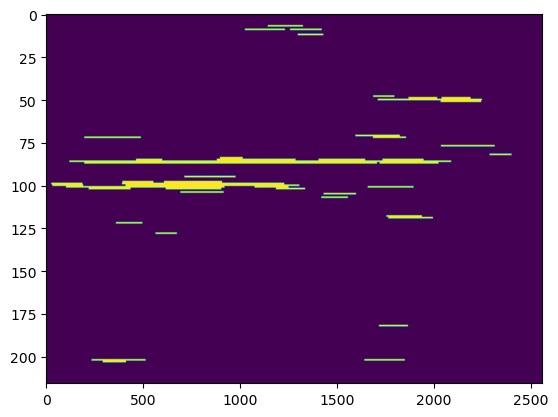

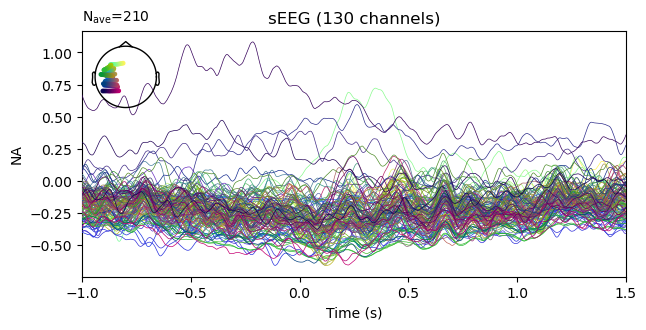

plotted non stimulus
Shape of HG_ev1._data: (210, 130, 2561)
Shape of HG_base._data: (1, 130, 102401)
Shape of sig1: (210, 130, 2561)
Shape of sig2: (39, 130, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   26.4s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   26.4s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   26.8s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   26.9s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   26.9s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   27.1s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:   50.4s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:   51.0s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:   51.2s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:   51.2s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:   51.3s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:   51.6s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  1.3min
[Parallel(

Saved channel names and indices to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0069\channels_D0069_GlobalLocal.txt
Saved significant channels for subject D0069 and mask responseIncongruent_experimentStartBase1secTo101Sec to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0069\sig_chans_D0069_responseIncongruent_experimentStartBase1secTo101Sec.json
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (163) does not match the number of channels in the raw data file (162). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (163) does not match the number of channels in the raw data file (162). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (163) does not match the number of channels in the raw data file (162). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 225 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (163) does not match the number of channels in the raw data file (162). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 162
filt channels before dropping bads: 162
outlier round 1 channels: ['RTAS7']
outlier round 1 channels: ['RTAS7', 'RTMM15']
outlier round 2 channels: ['RTAS7', 'RTMM15', 'RFO15']
outlier round 2 channels: ['RTAS7', 'RTMM15', 'RFO15', 'RTAS8']
outlier round 2 channels: ['RTAS7', 'RTMM15', 'RFO15', 'RTAS8', 'RTMM16']
Bad channels in 'good': ['RTAS7', 'RTMM15', 'RFO15', 'RTAS8', 'RTMM16']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 157
filt channels after dropping bads: 157
Reading 0 ... 6021119  =      0.000 ...  2940.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n25', 'Response/c75/n75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i

100%|██████████| 1/1 [00:51<00:00, 51.48s/it]


Reading 0 ... 4864645  =      0.000 ...  2375.315 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n25', 'Response/c75/n75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/n25', 'Stimulus/c75/n75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
55 

C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\3260712279.py:134: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
222 matching events found
No baseline correction applied


100%|██████████| 222/222 [04:29<00:00,  1.22s/it]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\3260712279.py:141: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\3260712279.py:142: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
about to plot if not stimulus


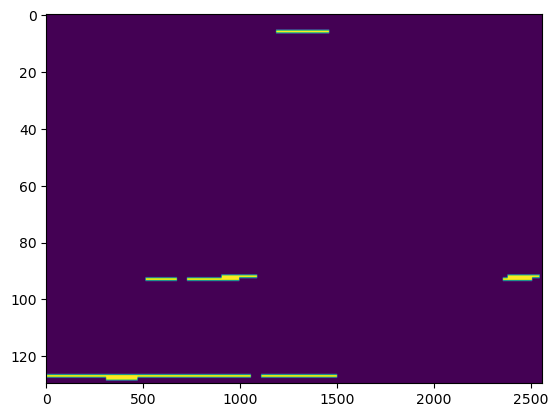

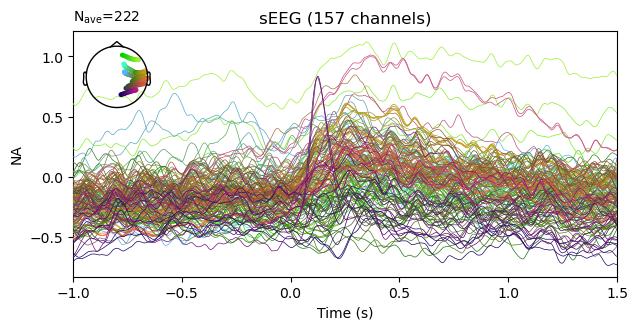

plotted non stimulus
Shape of HG_ev1._data: (222, 157, 2561)
Shape of HG_base._data: (1, 157, 102401)
Shape of sig1: (222, 157, 2561)
Shape of sig2: (39, 157, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   29.1s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   29.2s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   29.4s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   29.6s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   30.0s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   30.0s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:   53.7s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:   55.0s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:   55.1s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:   55.6s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:   55.7s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:   55.9s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  1.3min
[Parallel(

Saved channel names and indices to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0071\channels_D0071_GlobalLocal.txt
Saved significant channels for subject D0071 and mask responseIncongruent_experimentStartBase1secTo101Sec to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0071\sig_chans_D0071_responseIncongruent_experimentStartBase1secTo101Sec.json


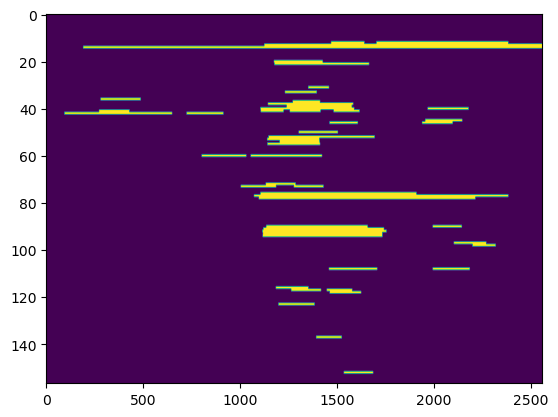

In [23]:
###
import sys
print(sys.path)
sys.path.append("C:/Users/jz421/Desktop/GlobalLocal/IEEG_Pipelines/") #need to do this cuz otherwise ieeg isn't added to path...

from ieeg.navigate import channel_outlier_marker, trial_ieeg, crop_empty_data, \
    outliers_to_nan
from ieeg.io import raw_from_layout, get_data
from ieeg.timefreq.utils import crop_pad
from ieeg.timefreq import gamma
from ieeg.calc.scaling import rescale
import mne
import os
import numpy as np
from ieeg.calc.reshape import make_data_same
from ieeg.calc.stats import time_perm_cluster

from misc_functions import calculate_RTs, save_channels_to_file, save_sig_chans
import matplotlib.pyplot as plt


def get_baseline(inst: mne.io.BaseRaw, base_times: tuple[float, float]):
    inst = inst.copy()
    inst.load_data()
    ch_type = inst.get_channel_types(only_data_chs=True)[0]
    inst.set_eeg_reference(ref_channels="average", ch_type=ch_type)

    adjusted_base_times = [base_times[0] - 0.5, base_times[1] + 0.5]
    trials = trial_ieeg(inst, "experimentStart", adjusted_base_times,
                        preload=True)
    # outliers_to_nan(trials, outliers=10)
    HG_base = gamma.extract(trials, copy=False, n_jobs=1)
    crop_pad(HG_base, "0.5s")
    del inst
    return HG_base


def plot_HG_and_stats(sub, task, output_name, event=None, times=(-1, 1.5),
                      base_times=(-0.5, 0), LAB_root=None, channels=None,
                      full_trial_base=False):
    """
    Plot high gamma (HG) and statistics for a given subject and task using specified event.

    Parameters:
    - sub (str): The subject identifier.
    - task (str): The task identifier.
    - output_name (str): The name for the output files.
    - event (str, optional): Event name to process. Defaults to None.
    - times (tuple, optional): A tuple indicating the start and end times for processing. Defaults to (-1, 1.5).
    - base_times (tuple, optional): A tuple indicating the start and end base times for processing. Defaults to (-0.5, 0).
    - LAB_root (str, optional): The root directory for the lab. Will be determined based on OS if not provided. Defaults to None.
    - channels (list of strings, optional): The channels to plot and get stats for. Default is all channels.
    - full_trial_base (boolean): Whether to use the full trial as the baseline period. Default is False.
    This function will process the provided event for a given subject and task.
    High gamma (HG) will be computed, and statistics will be calculated and plotted.
    The results will be saved to output files.
    """
    pass

subjects = ['D0057', 'D0059', 'D0063', 'D0065', 'D0069', 'D0071']
for sub in subjects:
    sub = sub
    output_name = "responseIncongruent_experimentStartBase1secTo101Sec"
    events = ["Response/i25","Response/i75"]
    times = (-1, 1.5)
    base_times = (1, 101)
    LAB_root = None
    channels = None
    full_trial_base = False

    if LAB_root is None:
        HOME = os.path.expanduser("~")
        if os.name == 'nt':  # windows
            LAB_root = os.path.join(HOME, "Box", "CoganLab")
        else:  # mac
            LAB_root = os.path.join(HOME, "Library", "CloudStorage", "Box-Box",
                                    "CoganLab")

    layout = get_data(task, root=LAB_root)
    filt = raw_from_layout(layout.derivatives['derivatives/clean'], subject=sub,
                        extension='.edf', desc='clean', preload=False)
    save_dir = os.path.join(layout.root, 'derivatives', 'freqFilt', 'figs', sub)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    ###

    good = crop_empty_data(filt)
    # %%

    print(f"good channels before dropping bads: {len(good.ch_names)}")
    print(f"filt channels before dropping bads: {len(filt.ch_names)}")

    good.info['bads'] = channel_outlier_marker(good, 3, 2)
    print("Bad channels in 'good':", good.info['bads'])

    filt.drop_channels(good.info['bads'])  # this has to come first cuz if you drop from good first, then good.info['bads'] is just empty
    good.drop_channels(good.info['bads'])

    print("Bad channels in 'good' after dropping once:", good.info['bads'])

    print(f"good channels after dropping bads: {len(good.ch_names)}")
    print(f"filt channels after dropping bads: {len(filt.ch_names)}")

    HG_base = get_baseline(filt, base_times)
    good.load_data()

    # If channels is None, use all channels
    if channels is None:
        channels = good.ch_names
    else:
        # Validate the provided channels
        invalid_channels = [ch for ch in channels if ch not in good.ch_names]
        if invalid_channels:
            raise ValueError(
                f"The following channels are not valid: {invalid_channels}")

        # Use only the specified channels
        good.pick_channels(channels)

    ch_type = filt.get_channel_types(only_data_chs=True)[0]
    good.set_eeg_reference(ref_channels="average", ch_type=ch_type)

    all_epochs_list = []

    for event in events:
    # Epoching and HG extraction for each specified event. Then concatenate all trials epochs objects together (do Stimulus/c25 and Stimulus/c75 for example, and combine to get all congruent trials)
        times_adj = [times[0] - 0.5, times[1] + 0.5]
        trials = trial_ieeg(good, event, times_adj, preload=True,
                            reject_by_annotation=False)
        all_epochs_list.append(trials)

    # Concatenate all trials
    all_trials = mne.concatenate_epochs(all_epochs_list)

    outliers_to_nan(all_trials, outliers=10)
    HG_ev1 = gamma.extract(all_trials, copy=False, n_jobs=1)
    crop_pad(HG_ev1, "0.5s")
    HG_ev1_rescaled = rescale(HG_ev1, HG_base, copy=True, mode='zscore')

    HG_base.decimate(2)
    HG_ev1.decimate(2)
    RTs, skipped = calculate_RTs(good)
    avg_RT = np.median(RTs)

    HG_ev1_evoke = HG_ev1.average(method=lambda x: np.nanmean(x, axis=0))
    HG_ev1_evoke_rescaled = HG_ev1_rescaled.average(method=lambda x: np.nanmean(x, axis=0))

    if event == "Stimulus":
        print('plotting stimulus')
        fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1)) #this line is not finishing...
        print('plotted')
        for ax in fig.axes:
            ax.axvline(x=avg_RT, color='r', linestyle='--')
        print('about to save')
        fig.savefig(save_dir + '_HG_ev1_Stimulus_zscore.png')
        print('saved')
    else:
        print('about to plot if not stimulus')
        fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1))
        print('plotted non stimulus')
        fig.savefig(save_dir + f'_HG_ev1_{output_name}_zscore.png')

    ###
    print(f"Shape of HG_ev1._data: {HG_ev1._data.shape}")
    print(f"Shape of HG_base._data: {HG_base._data.shape}")

    sig1 = HG_ev1._data
    sig2 = HG_base._data
    sig2 = make_data_same(sig2, sig1.shape)
    print(f"Shape of sig1: {sig1.shape}")
    print(f"Shape of sig2: {sig2.shape}")

    mat = time_perm_cluster(sig1, sig2, 0.05, n_jobs=6, ignore_adjacency=1)
    fig = plt.figure()
    plt.imshow(mat, aspect='auto')
    fig.savefig(save_dir + f'_{output_name}_stats.png', dpi=300)

    channels = good.ch_names

    #save channels with their indices 
    save_channels_to_file(channels, sub, task, save_dir)

    # save significant channels to a json
    save_sig_chans(f'{output_name}', mat, channels, sub, save_dir)

['c:\\Users\\jz421\\Desktop\\GlobalLocal', 'C:\\Users\\jz421\\Desktop\\GlobalLocal\\IEEG_Pipelines', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\python311.zip', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\DLLs', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg', '', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32\\lib', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\Pythonwin', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages\\win32', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\L

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 226 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 178
filt channels before dropping bads: 178
outlier round 1 channels: ['RAMT8']
outlier round 2 channels: ['RAMT8', 'RPI16']
outlier round 2 channels: ['RAMT8', 'RPI16', 'LAMT12']
Bad channels in 'good': ['RAMT8', 'RPI16', 'LAMT12']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 175
filt channels after dropping bads: 175
Reading 0 ... 8243199  =      0.000 ...  4025.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus

100%|██████████| 1/1 [01:04<00:00, 64.28s/it]


Reading 0 ... 5983997  =      0.000 ...  2921.874 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
448 matching events fou

C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\1080872271.py:134: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
448 matching events found
No baseline correction applied


100%|██████████| 448/448 [09:43<00:00,  1.30s/it]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\1080872271.py:141: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\1080872271.py:142: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
plotting stimulus


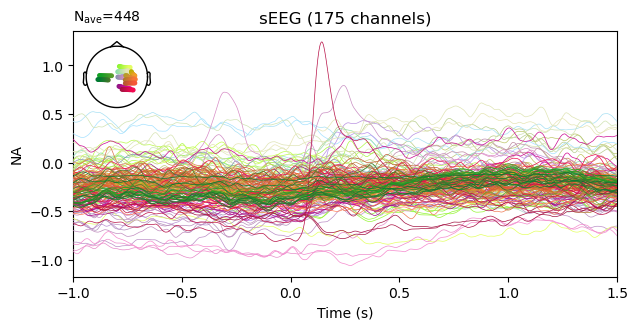

plotted
about to save
saved
Shape of HG_ev1._data: (448, 175, 2561)
Shape of HG_base._data: (1, 175, 102401)
Shape of sig1: (448, 175, 2561)
Shape of sig2: (39, 175, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   34.3s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   34.9s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   34.9s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   35.0s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   35.0s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   35.5s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  1.6min
[Parallel(

Saved channel names and indices to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0057\channels_D0057_GlobalLocal.txt
Saved significant channels for subject D0057 and mask stimulus_experimentStartBase1secTo101Sec to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0057\sig_chans_D0057_stimulus_experimentStartBase1secTo101Sec.json
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-01_desc-clean_c

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 226 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 184
filt channels before dropping bads: 184
outlier round 1 channels: ['LMPF15']
outlier round 2 channels: ['LMPF15', 'LASP3']
outlier round 2 channels: ['LMPF15', 'LASP3', 'LASP5']
outlier round 2 channels: ['LMPF15', 'LASP3', 'LASP5', 'LASP6']
outlier round 2 channels: ['LMPF15', 'LASP3', 'LASP5', 'LASP6', 'LMPT2']
outlier round 2 channels: ['LMPF15', 'LASP3', 'LASP5', 'LASP6', 'LMPT2', 'LPT16']
Bad channels in 'good': ['LMPF15', 'LASP3', 'LASP5', 'LASP6', 'LMPT2', 'LPT16']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 178
filt channels after dropping bads: 178
Reading 0 ... 8769535  =      0.000 ...  4282.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n25', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', '

100%|██████████| 1/1 [00:52<00:00, 52.27s/it]


Reading 0 ... 6582517  =      0.000 ...  3214.120 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n25', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', 'Response/i25/n75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/n25', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n25', 'Stimulus/i25/n75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
448

C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\1080872271.py:134: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
448 matching events found
No baseline correction applied


100%|██████████| 448/448 [08:42<00:00,  1.17s/it]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\1080872271.py:141: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\1080872271.py:142: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
plotting stimulus


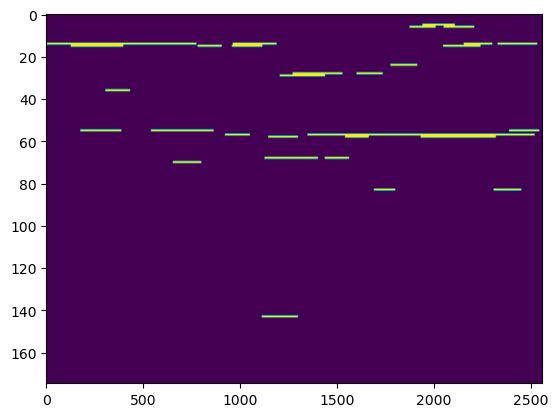

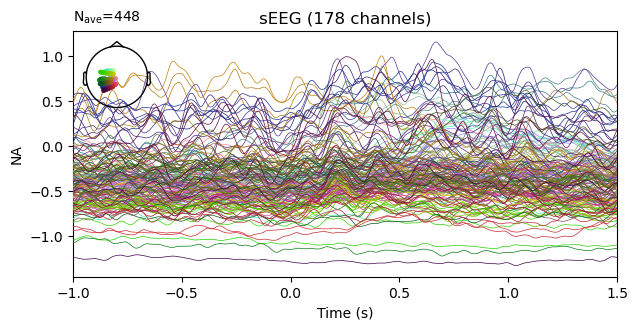

plotted
about to save
saved
Shape of HG_ev1._data: (448, 178, 2561)
Shape of HG_base._data: (1, 178, 102401)
Shape of sig1: (448, 178, 2561)
Shape of sig2: (39, 178, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   35.6s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   35.7s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   35.9s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   36.0s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   36.1s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   36.3s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  1.7min
[Parallel(

Saved channel names and indices to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0059\channels_D0059_GlobalLocal.txt
Saved significant channels for subject D0059 and mask stimulus_experimentStartBase1secTo101Sec to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0059\sig_chans_D0059_stimulus_experimentStartBase1secTo101Sec.json
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-01_desc-clean_c

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (241) does not match the number of channels in the raw data file (240). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 227 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (241) does not match the number of channels in the raw data file (240). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (241) does not match the number of channels in the raw data file (240). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 220 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (241) does not match the number of channels in the raw data file (240). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 240
filt channels before dropping bads: 240
outlier round 1 channels: ['LOF16']
outlier round 1 channels: ['LOF16', 'RMMT14']
outlier round 2 channels: ['LOF16', 'RMMT14', 'LOF10']
outlier round 2 channels: ['LOF16', 'RMMT14', 'LOF10', 'LOF14']
outlier round 2 channels: ['LOF16', 'RMMT14', 'LOF10', 'LOF14', 'ROF2']
outlier round 2 channels: ['LOF16', 'RMMT14', 'LOF10', 'LOF14', 'ROF2', 'RAMF4']
Bad channels in 'good': ['LOF16', 'RMMT14', 'LOF10', 'LOF14', 'ROF2', 'RAMF4']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 234
filt channels after dropping bads: 234
Reading 0 ... 4386815  =      0.000 ...  2142.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Resp

100%|██████████| 1/1 [01:10<00:00, 70.09s/it]


Reading 0 ... 3925799  =      0.000 ...  1916.894 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/n75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n25', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
448

C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\1080872271.py:134: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
448 matching events found
No baseline correction applied


100%|██████████| 448/448 [11:34<00:00,  1.55s/it]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\1080872271.py:141: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\1080872271.py:142: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
plotting stimulus


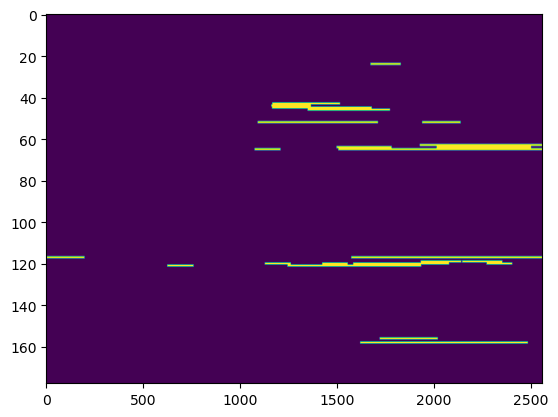

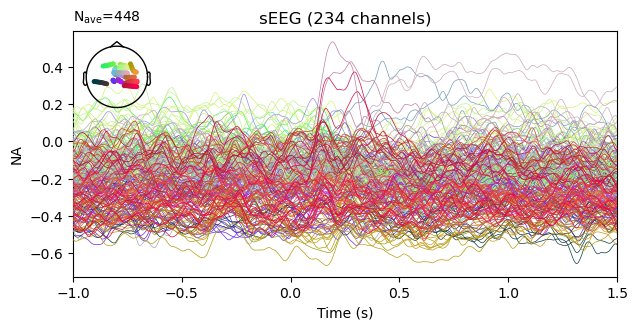

plotted
about to save
saved
Shape of HG_ev1._data: (448, 234, 2561)
Shape of HG_base._data: (1, 234, 102401)
Shape of sig1: (448, 234, 2561)
Shape of sig2: (39, 234, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   33.8s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   34.2s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   34.4s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   34.6s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   35.2s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   35.4s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  1.6min
[Parallel(

Saved channel names and indices to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0063\channels_D0063_GlobalLocal.txt
Saved significant channels for subject D0063 and mask stimulus_experimentStartBase1secTo101Sec to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0063\sig_chans_D0063_stimulus_experimentStartBase1secTo101Sec.json
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-01_desc-clean_c

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (221) does not match the number of channels in the raw data file (220). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 217 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (221) does not match the number of channels in the raw data file (220). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 225 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (221) does not match the number of channels in the raw data file (220). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 222 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (221) does not match the number of channels in the raw data file (220). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 220
filt channels before dropping bads: 220
outlier round 1 channels: ['RPIF3']
outlier round 1 channels: ['RPIF3', 'RAIO9']
outlier round 2 channels: ['RPIF3', 'RAIO9', 'RAMT15']
outlier round 2 channels: ['RPIF3', 'RAIO9', 'RAMT15', 'RMMT8']
Bad channels in 'good': ['RPIF3', 'RAIO9', 'RAMT15', 'RMMT8']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 216
filt channels after dropping bads: 216
Reading 0 ... 6350847  =      0.000 ...  3101.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s2

100%|██████████| 1/1 [01:03<00:00, 63.55s/it]


Reading 0 ... 5705315  =      0.000 ...  2785.798 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
448

C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\1080872271.py:134: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
448 matching events found
No baseline correction applied


100%|██████████| 448/448 [10:37<00:00,  1.42s/it]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\1080872271.py:141: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\1080872271.py:142: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
plotting stimulus


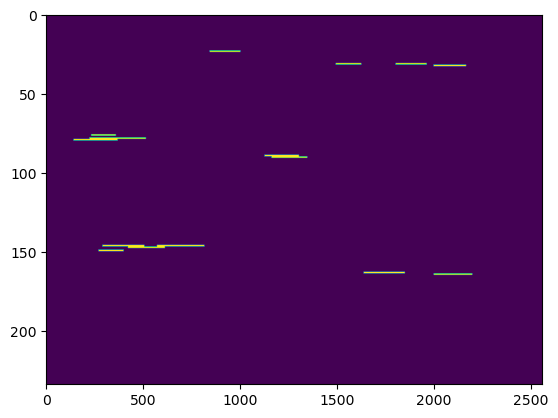

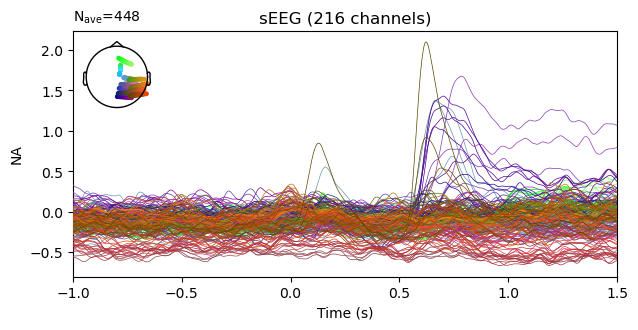

plotted
about to save
saved
Shape of HG_ev1._data: (448, 216, 2561)
Shape of HG_base._data: (1, 216, 102401)
Shape of sig1: (448, 216, 2561)
Shape of sig2: (39, 216, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   35.4s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   35.4s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   35.5s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   35.5s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   35.8s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   36.0s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  1.7min
[Parallel(

Saved channel names and indices to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0065\channels_D0065_GlobalLocal.txt
Saved significant channels for subject D0065 and mask stimulus_experimentStartBase1secTo101Sec to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0065\sig_chans_D0065_stimulus_experimentStartBase1secTo101Sec.json
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-01_desc-clean_c

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (133) does not match the number of channels in the raw data file (132). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 224 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (133) does not match the number of channels in the raw data file (132). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 224 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (133) does not match the number of channels in the raw data file (132). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 214 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (133) does not match the number of channels in the raw data file (132). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 132
filt channels before dropping bads: 132
outlier round 1 channels: ['LTMS11']
outlier round 2 channels: ['LTMS11', 'LTAS9']
Bad channels in 'good': ['LTMS11', 'LTAS9']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 130
filt channels after dropping bads: 130
Reading 0 ... 5701631  =      0.000 ...  2784.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c

100%|██████████| 1/1 [00:37<00:00, 37.05s/it]


Reading 0 ... 5221780  =      0.000 ...  2549.697 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n25', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
448

C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\1080872271.py:134: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
448 matching events found
No baseline correction applied


100%|██████████| 448/448 [06:06<00:00,  1.22it/s]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\1080872271.py:141: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\1080872271.py:142: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
plotting stimulus


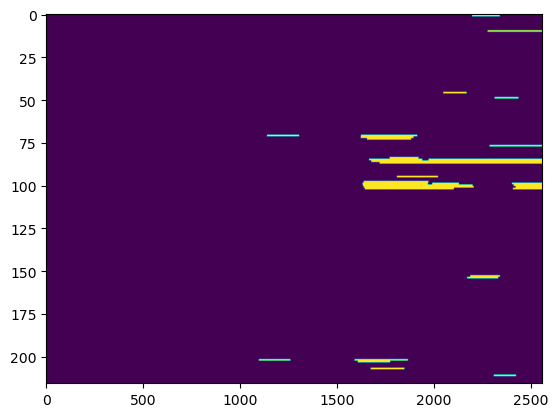

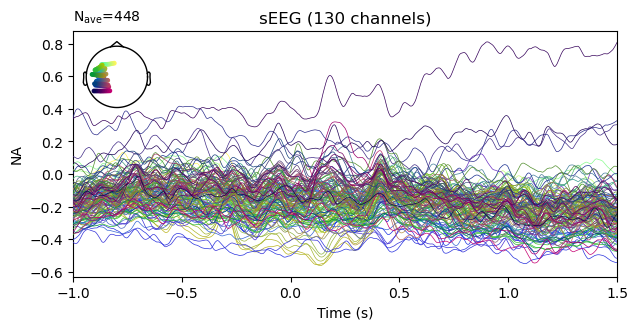

plotted
about to save
saved
Shape of HG_ev1._data: (448, 130, 2561)
Shape of HG_base._data: (1, 130, 102401)
Shape of sig1: (448, 130, 2561)
Shape of sig2: (39, 130, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   33.4s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   34.4s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   34.8s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   34.9s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   35.0s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   35.2s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  1.6min
[Parallel(

Saved channel names and indices to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0069\channels_D0069_GlobalLocal.txt
Saved significant channels for subject D0069 and mask stimulus_experimentStartBase1secTo101Sec to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0069\sig_chans_D0069_stimulus_experimentStartBase1secTo101Sec.json
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-01_desc-clean_c

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (163) does not match the number of channels in the raw data file (162). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (163) does not match the number of channels in the raw data file (162). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (163) does not match the number of channels in the raw data file (162). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 225 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (163) does not match the number of channels in the raw data file (162). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 162
filt channels before dropping bads: 162
outlier round 1 channels: ['RTAS7']
outlier round 1 channels: ['RTAS7', 'RTMM15']
outlier round 2 channels: ['RTAS7', 'RTMM15', 'RFO15']
outlier round 2 channels: ['RTAS7', 'RTMM15', 'RFO15', 'RTAS8']
outlier round 2 channels: ['RTAS7', 'RTMM15', 'RFO15', 'RTAS8', 'RTMM16']
Bad channels in 'good': ['RTAS7', 'RTMM15', 'RFO15', 'RTAS8', 'RTMM16']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 157
filt channels after dropping bads: 157
Reading 0 ... 6021119  =      0.000 ...  2940.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n25', 'Response/c75/n75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i

100%|██████████| 1/1 [00:46<00:00, 46.32s/it]


Reading 0 ... 4864645  =      0.000 ...  2375.315 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n25', 'Response/c75/n75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/n25', 'Stimulus/c75/n75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
448

C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\1080872271.py:134: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
448 matching events found
No baseline correction applied


100%|██████████| 448/448 [07:26<00:00,  1.00it/s]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\1080872271.py:141: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\1080872271.py:142: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
plotting stimulus


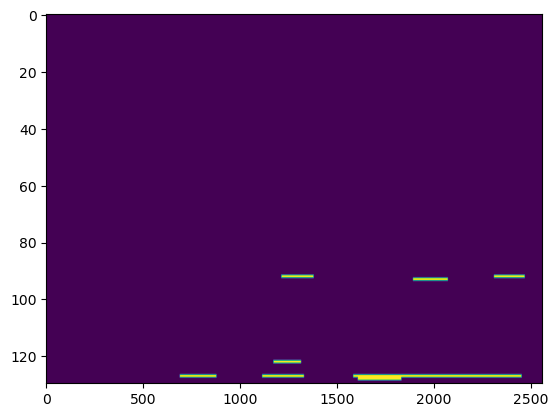

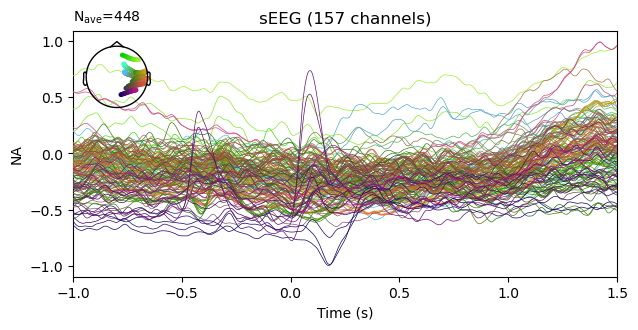

plotted
about to save
saved
Shape of HG_ev1._data: (448, 157, 2561)
Shape of HG_base._data: (1, 157, 102401)
Shape of sig1: (448, 157, 2561)
Shape of sig2: (39, 157, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   33.3s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   33.7s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   33.8s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   33.9s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   34.0s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   34.5s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  1.6min
[Parallel(

Saved channel names and indices to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0071\channels_D0071_GlobalLocal.txt
Saved significant channels for subject D0071 and mask stimulus_experimentStartBase1secTo101Sec to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0071\sig_chans_D0071_stimulus_experimentStartBase1secTo101Sec.json


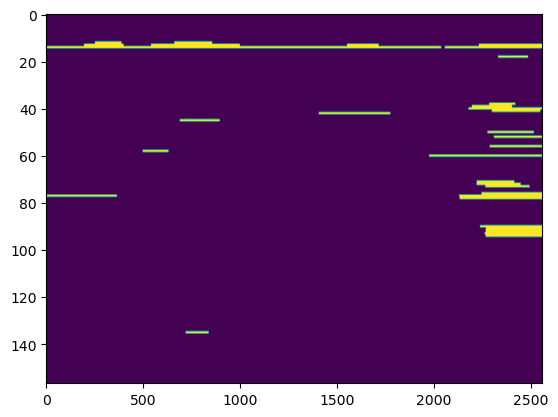

In [20]:
###
import sys
print(sys.path)
sys.path.append("C:/Users/jz421/Desktop/GlobalLocal/IEEG_Pipelines/") #need to do this cuz otherwise ieeg isn't added to path...

from ieeg.navigate import channel_outlier_marker, trial_ieeg, crop_empty_data, \
    outliers_to_nan
from ieeg.io import raw_from_layout, get_data
from ieeg.timefreq.utils import crop_pad
from ieeg.timefreq import gamma
from ieeg.calc.scaling import rescale
import mne
import os
import numpy as np
from ieeg.calc.reshape import make_data_same
from ieeg.calc.stats import time_perm_cluster

from misc_functions import calculate_RTs, save_channels_to_file, save_sig_chans
import matplotlib.pyplot as plt


def get_baseline(inst: mne.io.BaseRaw, base_times: tuple[float, float]):
    inst = inst.copy()
    inst.load_data()
    ch_type = inst.get_channel_types(only_data_chs=True)[0]
    inst.set_eeg_reference(ref_channels="average", ch_type=ch_type)

    adjusted_base_times = [base_times[0] - 0.5, base_times[1] + 0.5]
    trials = trial_ieeg(inst, "experimentStart", adjusted_base_times,
                        preload=True)
    # outliers_to_nan(trials, outliers=10)
    HG_base = gamma.extract(trials, copy=False, n_jobs=1)
    crop_pad(HG_base, "0.5s")
    del inst
    return HG_base


def plot_HG_and_stats(sub, task, output_name, event=None, times=(-1, 1.5),
                      base_times=(-0.5, 0), LAB_root=None, channels=None,
                      full_trial_base=False):
    """
    Plot high gamma (HG) and statistics for a given subject and task using specified event.

    Parameters:
    - sub (str): The subject identifier.
    - task (str): The task identifier.
    - output_name (str): The name for the output files.
    - event (str, optional): Event name to process. Defaults to None.
    - times (tuple, optional): A tuple indicating the start and end times for processing. Defaults to (-1, 1.5).
    - base_times (tuple, optional): A tuple indicating the start and end base times for processing. Defaults to (-0.5, 0).
    - LAB_root (str, optional): The root directory for the lab. Will be determined based on OS if not provided. Defaults to None.
    - channels (list of strings, optional): The channels to plot and get stats for. Default is all channels.
    - full_trial_base (boolean): Whether to use the full trial as the baseline period. Default is False.
    This function will process the provided event for a given subject and task.
    High gamma (HG) will be computed, and statistics will be calculated and plotted.
    The results will be saved to output files.
    """
    pass

subjects = ['D0057', 'D0059', 'D0063', 'D0065', 'D0069', 'D0071']
for sub in subjects:
    sub = sub
    output_name = "stimulus_experimentStartBase1secTo101Sec"
    events = ["Stimulus"]
    times = (-1, 1.5)
    base_times = (1, 101)
    LAB_root = None
    channels = None
    full_trial_base = False

    if LAB_root is None:
        HOME = os.path.expanduser("~")
        if os.name == 'nt':  # windows
            LAB_root = os.path.join(HOME, "Box", "CoganLab")
        else:  # mac
            LAB_root = os.path.join(HOME, "Library", "CloudStorage", "Box-Box",
                                    "CoganLab")

    layout = get_data(task, root=LAB_root)
    filt = raw_from_layout(layout.derivatives['derivatives/clean'], subject=sub,
                        extension='.edf', desc='clean', preload=False)
    save_dir = os.path.join(layout.root, 'derivatives', 'freqFilt', 'figs', sub)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    ###

    good = crop_empty_data(filt)
    # %%

    print(f"good channels before dropping bads: {len(good.ch_names)}")
    print(f"filt channels before dropping bads: {len(filt.ch_names)}")

    good.info['bads'] = channel_outlier_marker(good, 3, 2)
    print("Bad channels in 'good':", good.info['bads'])

    filt.drop_channels(good.info['bads'])  # this has to come first cuz if you drop from good first, then good.info['bads'] is just empty
    good.drop_channels(good.info['bads'])

    print("Bad channels in 'good' after dropping once:", good.info['bads'])

    print(f"good channels after dropping bads: {len(good.ch_names)}")
    print(f"filt channels after dropping bads: {len(filt.ch_names)}")

    HG_base = get_baseline(filt, base_times)
    good.load_data()

    # If channels is None, use all channels
    if channels is None:
        channels = good.ch_names
    else:
        # Validate the provided channels
        invalid_channels = [ch for ch in channels if ch not in good.ch_names]
        if invalid_channels:
            raise ValueError(
                f"The following channels are not valid: {invalid_channels}")

        # Use only the specified channels
        good.pick_channels(channels)

    ch_type = filt.get_channel_types(only_data_chs=True)[0]
    good.set_eeg_reference(ref_channels="average", ch_type=ch_type)

    all_epochs_list = []

    for event in events:
    # Epoching and HG extraction for each specified event. Then concatenate all trials epochs objects together (do Stimulus/c25 and Stimulus/c75 for example, and combine to get all congruent trials)
        times_adj = [times[0] - 0.5, times[1] + 0.5]
        trials = trial_ieeg(good, event, times_adj, preload=True,
                            reject_by_annotation=False)
        all_epochs_list.append(trials)

    # Concatenate all trials
    all_trials = mne.concatenate_epochs(all_epochs_list)

    outliers_to_nan(all_trials, outliers=10)
    HG_ev1 = gamma.extract(all_trials, copy=False, n_jobs=1)
    crop_pad(HG_ev1, "0.5s")
    HG_ev1_rescaled = rescale(HG_ev1, HG_base, copy=True, mode='zscore')

    HG_base.decimate(2)
    HG_ev1.decimate(2)
    RTs, skipped = calculate_RTs(good)
    avg_RT = np.median(RTs)

    HG_ev1_evoke = HG_ev1.average(method=lambda x: np.nanmean(x, axis=0))
    HG_ev1_evoke_rescaled = HG_ev1_rescaled.average(method=lambda x: np.nanmean(x, axis=0))

    if event == "Stimulus":
        print('plotting stimulus')
        fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1)) #this line is not finishing...
        print('plotted')
        for ax in fig.axes:
            ax.axvline(x=avg_RT, color='r', linestyle='--')
        print('about to save')
        fig.savefig(save_dir + '_HG_ev1_Stimulus_zscore.png')
        print('saved')
    else:
        print('about to plot if not stimulus')
        fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1))
        print('plotted non stimulus')
        fig.savefig(save_dir + f'_HG_ev1_{output_name}_zscore.png')

    ###
    print(f"Shape of HG_ev1._data: {HG_ev1._data.shape}")
    print(f"Shape of HG_base._data: {HG_base._data.shape}")

    sig1 = HG_ev1._data
    sig2 = HG_base._data
    sig2 = make_data_same(sig2, sig1.shape)
    print(f"Shape of sig1: {sig1.shape}")
    print(f"Shape of sig2: {sig2.shape}")

    mat = time_perm_cluster(sig1, sig2, 0.05, n_jobs=6, ignore_adjacency=1)
    fig = plt.figure()
    plt.imshow(mat, aspect='auto')
    fig.savefig(save_dir + f'_{output_name}_stats.png', dpi=300)

    channels = good.ch_names

    #save channels with their indices 
    save_channels_to_file(channels, sub, task, save_dir)

    # save significant channels to a json
    save_sig_chans(f'{output_name}', mat, channels, sub, save_dir)

['c:\\Users\\jz421\\Desktop\\GlobalLocal', 'C:\\Users\\jz421\\Desktop\\GlobalLocal\\IEEG_Pipelines', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\python311.zip', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\DLLs', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg', '', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32\\lib', 'C:\\Users\\jz421\\AppData\\Roaming\\Python\\Python311\\site-packages\\Pythonwin', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages\\win32', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\jz421\\AppData\\Local\\anaconda3\\envs\\ieeg\\L

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 226 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 178
filt channels before dropping bads: 178
outlier round 1 channels: ['RAMT8']
outlier round 2 channels: ['RAMT8', 'RPI16']
outlier round 2 channels: ['RAMT8', 'RPI16', 'LAMT12']
Bad channels in 'good': ['RAMT8', 'RPI16', 'LAMT12']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 175
filt channels after dropping bads: 175
Reading 0 ... 8243199  =      0.000 ...  4025.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus

100%|██████████| 1/1 [00:52<00:00, 52.79s/it]


Reading 0 ... 5983997  =      0.000 ...  2921.874 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
436 matching events fou

C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\4272485224.py:134: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
436 matching events found
No baseline correction applied


100%|██████████| 436/436 [08:47<00:00,  1.21s/it]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\4272485224.py:141: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\4272485224.py:142: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
about to plot if not stimulus


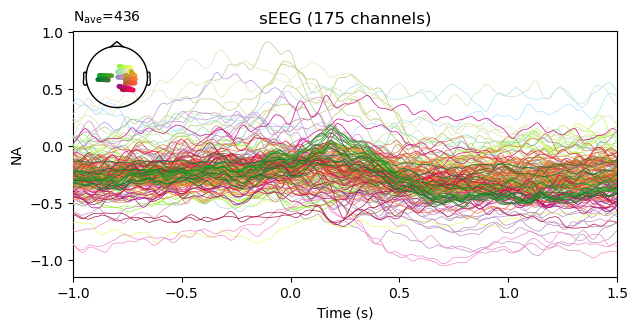

plotted non stimulus
Shape of HG_ev1._data: (436, 175, 2561)
Shape of HG_base._data: (1, 175, 102401)
Shape of sig1: (436, 175, 2561)
Shape of sig2: (39, 175, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   35.3s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   35.5s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   35.5s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   35.6s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   35.7s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   35.8s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  1.7min
[Parallel(

Saved channel names and indices to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0057\channels_D0057_GlobalLocal.txt
Saved significant channels for subject D0057 and mask response_experimentStartBase1secTo101Sec to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0057\sig_chans_D0057_response_experimentStartBase1secTo101Sec.json
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-01_desc-clean_c

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 226 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 184
filt channels before dropping bads: 184
outlier round 1 channels: ['LMPF15']
outlier round 2 channels: ['LMPF15', 'LASP3']
outlier round 2 channels: ['LMPF15', 'LASP3', 'LASP5']
outlier round 2 channels: ['LMPF15', 'LASP3', 'LASP5', 'LASP6']
outlier round 2 channels: ['LMPF15', 'LASP3', 'LASP5', 'LASP6', 'LMPT2']
outlier round 2 channels: ['LMPF15', 'LASP3', 'LASP5', 'LASP6', 'LMPT2', 'LPT16']
Bad channels in 'good': ['LMPF15', 'LASP3', 'LASP5', 'LASP6', 'LMPT2', 'LPT16']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 178
filt channels after dropping bads: 178
Reading 0 ... 8769535  =      0.000 ...  4282.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n25', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', '

100%|██████████| 1/1 [00:53<00:00, 53.88s/it]


Reading 0 ... 6582517  =      0.000 ...  3214.120 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n25', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', 'Response/i25/n75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/n25', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n25', 'Stimulus/i25/n75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
447

C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\4272485224.py:134: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
447 matching events found
No baseline correction applied


100%|██████████| 447/447 [09:12<00:00,  1.24s/it]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\4272485224.py:141: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\4272485224.py:142: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
about to plot if not stimulus


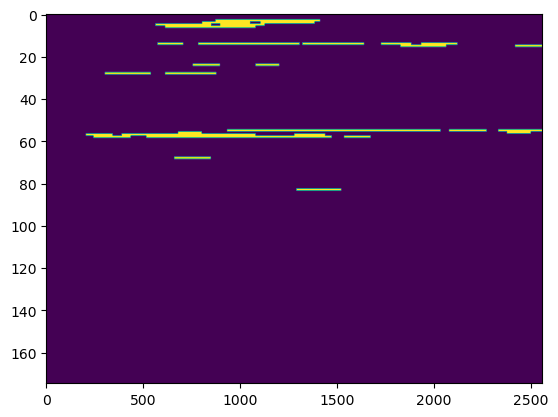

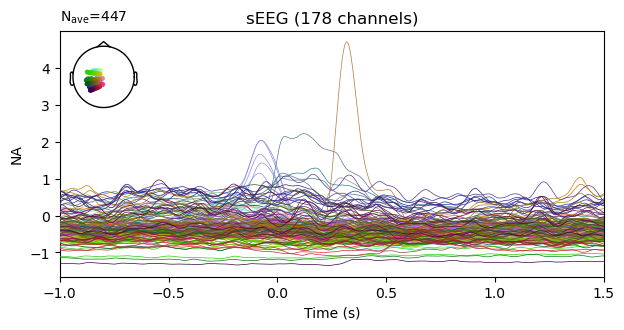

plotted non stimulus
Shape of HG_ev1._data: (447, 178, 2561)
Shape of HG_base._data: (1, 178, 102401)
Shape of sig1: (447, 178, 2561)
Shape of sig2: (39, 178, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   36.3s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   36.5s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   36.6s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   36.6s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   36.7s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   36.9s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  1.7min
[Parallel(

Saved channel names and indices to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0059\channels_D0059_GlobalLocal.txt
Saved significant channels for subject D0059 and mask response_experimentStartBase1secTo101Sec to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0059\sig_chans_D0059_response_experimentStartBase1secTo101Sec.json
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-01_desc-clean_c

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (241) does not match the number of channels in the raw data file (240). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 227 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (241) does not match the number of channels in the raw data file (240). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (241) does not match the number of channels in the raw data file (240). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0063\ieeg\sub-D0063_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 220 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (241) does not match the number of channels in the raw data file (240). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 240
filt channels before dropping bads: 240
outlier round 1 channels: ['LOF16']
outlier round 1 channels: ['LOF16', 'RMMT14']
outlier round 2 channels: ['LOF16', 'RMMT14', 'LOF10']
outlier round 2 channels: ['LOF16', 'RMMT14', 'LOF10', 'LOF14']
outlier round 2 channels: ['LOF16', 'RMMT14', 'LOF10', 'LOF14', 'ROF2']
outlier round 2 channels: ['LOF16', 'RMMT14', 'LOF10', 'LOF14', 'ROF2', 'RAMF4']
Bad channels in 'good': ['LOF16', 'RMMT14', 'LOF10', 'LOF14', 'ROF2', 'RAMF4']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 234
filt channels after dropping bads: 234
Reading 0 ... 4386815  =      0.000 ...  2142.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Resp

100%|██████████| 1/1 [01:11<00:00, 71.37s/it]


Reading 0 ... 3925799  =      0.000 ...  1916.894 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/n75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n25', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
441

C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\4272485224.py:134: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
441 matching events found
No baseline correction applied


100%|██████████| 441/441 [11:57<00:00,  1.63s/it]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\4272485224.py:141: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\4272485224.py:142: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
about to plot if not stimulus


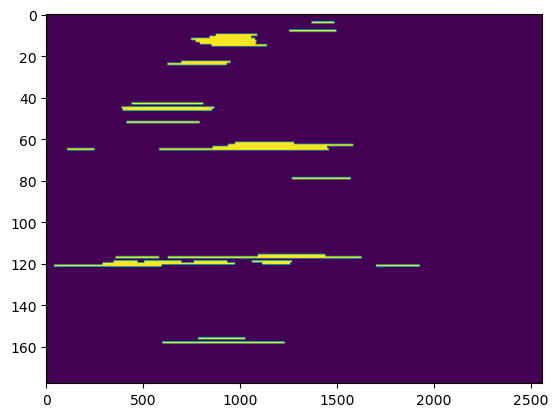

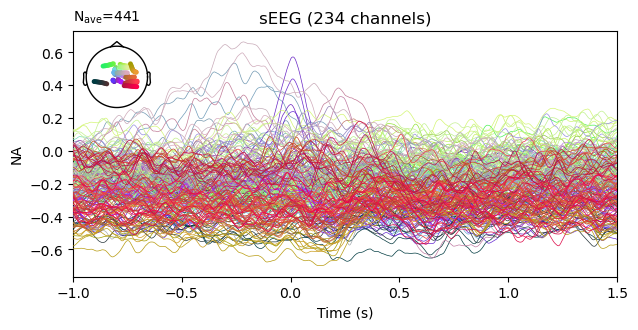

plotted non stimulus
Shape of HG_ev1._data: (441, 234, 2561)
Shape of HG_base._data: (1, 234, 102401)
Shape of sig1: (441, 234, 2561)
Shape of sig2: (39, 234, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   35.5s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   35.6s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   35.8s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   36.1s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   36.2s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   36.2s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  1.7min
[Parallel(

Saved channel names and indices to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0063\channels_D0063_GlobalLocal.txt
Saved significant channels for subject D0063 and mask response_experimentStartBase1secTo101Sec to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0063\sig_chans_D0063_response_experimentStartBase1secTo101Sec.json
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-01_desc-clean_c

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (221) does not match the number of channels in the raw data file (220). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 217 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (221) does not match the number of channels in the raw data file (220). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 225 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (221) does not match the number of channels in the raw data file (220). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0065\ieeg\sub-D0065_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 222 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (221) does not match the number of channels in the raw data file (220). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 220
filt channels before dropping bads: 220
outlier round 1 channels: ['RPIF3']
outlier round 1 channels: ['RPIF3', 'RAIO9']
outlier round 2 channels: ['RPIF3', 'RAIO9', 'RAMT15']
outlier round 2 channels: ['RPIF3', 'RAIO9', 'RAMT15', 'RMMT8']
Bad channels in 'good': ['RPIF3', 'RAIO9', 'RAMT15', 'RMMT8']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 216
filt channels after dropping bads: 216
Reading 0 ... 6350847  =      0.000 ...  3101.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s2

100%|██████████| 1/1 [01:05<00:00, 65.04s/it]


Reading 0 ... 5705315  =      0.000 ...  2785.798 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
418

C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\4272485224.py:134: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
418 matching events found
No baseline correction applied


100%|██████████| 418/418 [10:24<00:00,  1.49s/it]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\4272485224.py:141: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\4272485224.py:142: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
about to plot if not stimulus


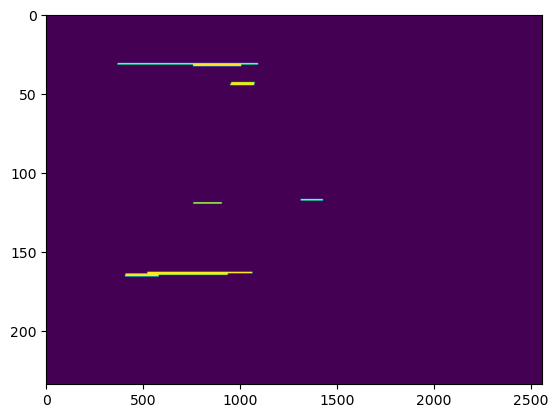

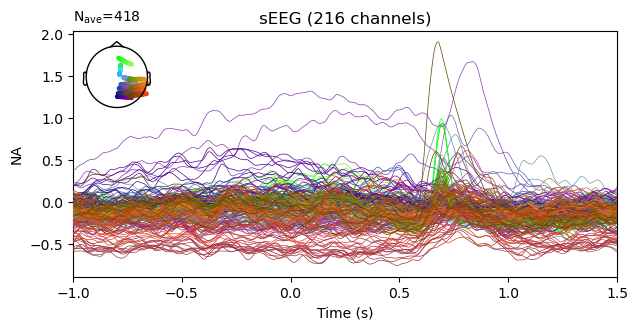

plotted non stimulus
Shape of HG_ev1._data: (418, 216, 2561)
Shape of HG_base._data: (1, 216, 102401)
Shape of sig1: (418, 216, 2561)
Shape of sig2: (39, 216, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   35.0s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   35.2s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   35.3s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   35.3s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   35.3s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   35.3s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  1.7min
[Parallel(

Saved channel names and indices to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0065\channels_D0065_GlobalLocal.txt
Saved significant channels for subject D0065 and mask response_experimentStartBase1secTo101Sec to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0065\sig_chans_D0065_response_experimentStartBase1secTo101Sec.json
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-01_desc-clean_c

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (133) does not match the number of channels in the raw data file (132). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 224 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (133) does not match the number of channels in the raw data file (132). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 224 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (133) does not match the number of channels in the raw data file (132). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0069\ieeg\sub-D0069_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 214 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (133) does not match the number of channels in the raw data file (132). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 132
filt channels before dropping bads: 132
outlier round 1 channels: ['LTMS11']
outlier round 2 channels: ['LTMS11', 'LTAS9']
Bad channels in 'good': ['LTMS11', 'LTAS9']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 130
filt channels after dropping bads: 130
Reading 0 ... 5701631  =      0.000 ...  2784.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c

100%|██████████| 1/1 [00:38<00:00, 38.97s/it]


Reading 0 ... 5221780  =      0.000 ...  2549.697 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n25', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
424

C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\4272485224.py:134: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
424 matching events found
No baseline correction applied


100%|██████████| 424/424 [06:04<00:00,  1.16it/s]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\4272485224.py:141: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\4272485224.py:142: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
about to plot if not stimulus


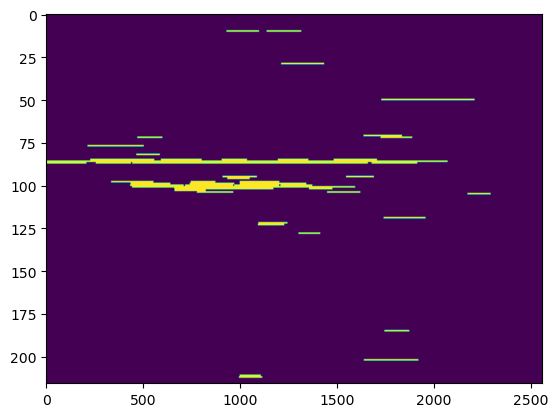

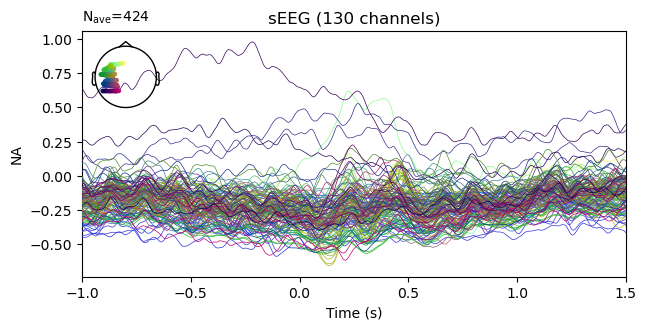

plotted non stimulus
Shape of HG_ev1._data: (424, 130, 2561)
Shape of HG_base._data: (1, 130, 102401)
Shape of sig1: (424, 130, 2561)
Shape of sig2: (39, 130, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   33.5s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   33.5s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   33.7s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   33.8s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   33.9s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   34.1s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  1.6min
[Parallel(

Saved channel names and indices to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0069\channels_D0069_GlobalLocal.txt
Saved significant channels for subject D0069 and mask response_experimentStartBase1secTo101Sec to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0069\sig_chans_D0069_response_experimentStartBase1secTo101Sec.json
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-01_desc-clean_c

C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (163) does not match the number of channels in the raw data file (162). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (163) does not match the number of channels in the raw data file (162). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (163) does not match the number of channels in the raw data file (162). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0071\ieeg\sub-D0071_acq-01_space-ACPC_electrodes.tsv.


C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Omitted 225 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: The number of channels in the channels.tsv sidecar file (163) does not match the number of channels in the raw data file (162). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)
C:\Users\jz421\Desktop\GlobalLocal\IEEG_Pipelines\ieeg\io.py:113: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path, verbose=verbose)


good channels before dropping bads: 162
filt channels before dropping bads: 162
outlier round 1 channels: ['RTAS7']
outlier round 1 channels: ['RTAS7', 'RTMM15']
outlier round 2 channels: ['RTAS7', 'RTMM15', 'RFO15']
outlier round 2 channels: ['RTAS7', 'RTMM15', 'RFO15', 'RTAS8']
outlier round 2 channels: ['RTAS7', 'RTMM15', 'RFO15', 'RTAS8', 'RTMM16']
Bad channels in 'good': ['RTAS7', 'RTMM15', 'RFO15', 'RTAS8', 'RTMM16']
Bad channels in 'good' after dropping once: []
good channels after dropping bads: 157
filt channels after dropping bads: 157
Reading 0 ... 6021119  =      0.000 ...  2940.000 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n25', 'Response/c75/n75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i

100%|██████████| 1/1 [00:47<00:00, 47.87s/it]


Reading 0 ... 4864645  =      0.000 ...  2375.315 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/n75', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n25', 'Response/c75/n75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/n75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/n25', 'Stimulus/c75/n75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75', 'experimentStart']
Not setting metadata
444

C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\4272485224.py:134: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_trials = mne.concatenate_epochs(all_epochs_list)


Not setting metadata
444 matching events found
No baseline correction applied


100%|██████████| 444/444 [08:07<00:00,  1.10s/it]


Applying baseline correction (mode: zscore)


C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\4272485224.py:141: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_base.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_5184\4272485224.py:142: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  HG_ev1.decimate(2)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
about to plot if not stimulus


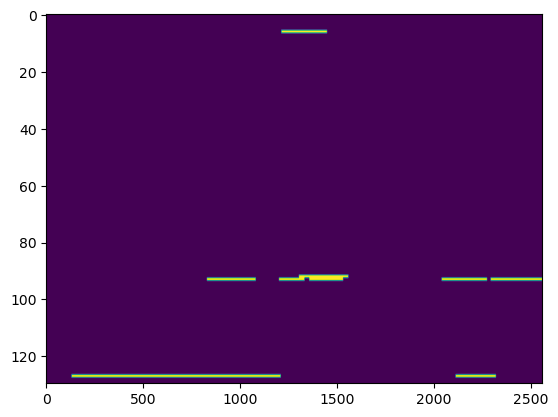

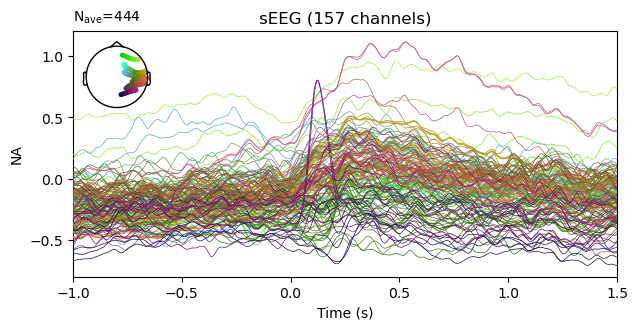

plotted non stimulus
Shape of HG_ev1._data: (444, 157, 2561)
Shape of HG_base._data: (1, 157, 102401)
Shape of sig1: (444, 157, 2561)
Shape of sig2: (39, 157, 2561)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   35.7s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   36.0s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   36.0s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   36.1s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   36.1s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   36.2s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  1.7min
[Parallel(

Saved channel names and indices to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0071\channels_D0071_GlobalLocal.txt
Saved significant channels for subject D0071 and mask response_experimentStartBase1secTo101Sec to C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\freqFilt\figs\D0071\sig_chans_D0071_response_experimentStartBase1secTo101Sec.json


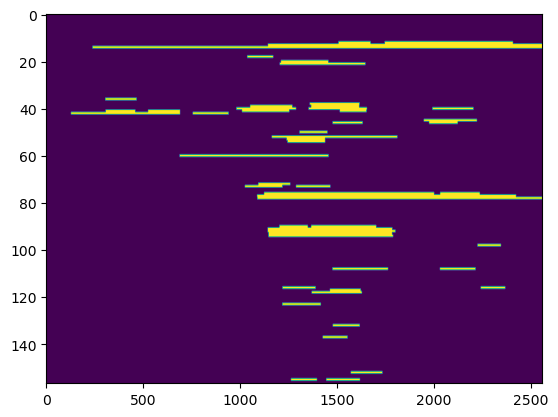

In [21]:
###
import sys
print(sys.path)
sys.path.append("C:/Users/jz421/Desktop/GlobalLocal/IEEG_Pipelines/") #need to do this cuz otherwise ieeg isn't added to path...

from ieeg.navigate import channel_outlier_marker, trial_ieeg, crop_empty_data, \
    outliers_to_nan
from ieeg.io import raw_from_layout, get_data
from ieeg.timefreq.utils import crop_pad
from ieeg.timefreq import gamma
from ieeg.calc.scaling import rescale
import mne
import os
import numpy as np
from ieeg.calc.reshape import make_data_same
from ieeg.calc.stats import time_perm_cluster

from misc_functions import calculate_RTs, save_channels_to_file, save_sig_chans
import matplotlib.pyplot as plt


def get_baseline(inst: mne.io.BaseRaw, base_times: tuple[float, float]):
    inst = inst.copy()
    inst.load_data()
    ch_type = inst.get_channel_types(only_data_chs=True)[0]
    inst.set_eeg_reference(ref_channels="average", ch_type=ch_type)

    adjusted_base_times = [base_times[0] - 0.5, base_times[1] + 0.5]
    trials = trial_ieeg(inst, "experimentStart", adjusted_base_times,
                        preload=True)
    # outliers_to_nan(trials, outliers=10)
    HG_base = gamma.extract(trials, copy=False, n_jobs=1)
    crop_pad(HG_base, "0.5s")
    del inst
    return HG_base


def plot_HG_and_stats(sub, task, output_name, event=None, times=(-1, 1.5),
                      base_times=(-0.5, 0), LAB_root=None, channels=None,
                      full_trial_base=False):
    """
    Plot high gamma (HG) and statistics for a given subject and task using specified event.

    Parameters:
    - sub (str): The subject identifier.
    - task (str): The task identifier.
    - output_name (str): The name for the output files.
    - event (str, optional): Event name to process. Defaults to None.
    - times (tuple, optional): A tuple indicating the start and end times for processing. Defaults to (-1, 1.5).
    - base_times (tuple, optional): A tuple indicating the start and end base times for processing. Defaults to (-0.5, 0).
    - LAB_root (str, optional): The root directory for the lab. Will be determined based on OS if not provided. Defaults to None.
    - channels (list of strings, optional): The channels to plot and get stats for. Default is all channels.
    - full_trial_base (boolean): Whether to use the full trial as the baseline period. Default is False.
    This function will process the provided event for a given subject and task.
    High gamma (HG) will be computed, and statistics will be calculated and plotted.
    The results will be saved to output files.
    """
    pass

subjects = ['D0057', 'D0059', 'D0063', 'D0065', 'D0069', 'D0071']
for sub in subjects:
    sub = sub
    output_name = "response_experimentStartBase1secTo101Sec"
    events = ["Response"]
    times = (-1, 1.5)
    base_times = (1, 101)
    LAB_root = None
    channels = None
    full_trial_base = False

    if LAB_root is None:
        HOME = os.path.expanduser("~")
        if os.name == 'nt':  # windows
            LAB_root = os.path.join(HOME, "Box", "CoganLab")
        else:  # mac
            LAB_root = os.path.join(HOME, "Library", "CloudStorage", "Box-Box",
                                    "CoganLab")

    layout = get_data(task, root=LAB_root)
    filt = raw_from_layout(layout.derivatives['derivatives/clean'], subject=sub,
                        extension='.edf', desc='clean', preload=False)
    save_dir = os.path.join(layout.root, 'derivatives', 'freqFilt', 'figs', sub)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    ###

    good = crop_empty_data(filt)
    # %%

    print(f"good channels before dropping bads: {len(good.ch_names)}")
    print(f"filt channels before dropping bads: {len(filt.ch_names)}")

    good.info['bads'] = channel_outlier_marker(good, 3, 2)
    print("Bad channels in 'good':", good.info['bads'])

    filt.drop_channels(good.info['bads'])  # this has to come first cuz if you drop from good first, then good.info['bads'] is just empty
    good.drop_channels(good.info['bads'])

    print("Bad channels in 'good' after dropping once:", good.info['bads'])

    print(f"good channels after dropping bads: {len(good.ch_names)}")
    print(f"filt channels after dropping bads: {len(filt.ch_names)}")

    HG_base = get_baseline(filt, base_times)
    good.load_data()

    # If channels is None, use all channels
    if channels is None:
        channels = good.ch_names
    else:
        # Validate the provided channels
        invalid_channels = [ch for ch in channels if ch not in good.ch_names]
        if invalid_channels:
            raise ValueError(
                f"The following channels are not valid: {invalid_channels}")

        # Use only the specified channels
        good.pick_channels(channels)

    ch_type = filt.get_channel_types(only_data_chs=True)[0]
    good.set_eeg_reference(ref_channels="average", ch_type=ch_type)

    all_epochs_list = []

    for event in events:
    # Epoching and HG extraction for each specified event. Then concatenate all trials epochs objects together (do Stimulus/c25 and Stimulus/c75 for example, and combine to get all congruent trials)
        times_adj = [times[0] - 0.5, times[1] + 0.5]
        trials = trial_ieeg(good, event, times_adj, preload=True,
                            reject_by_annotation=False)
        all_epochs_list.append(trials)

    # Concatenate all trials
    all_trials = mne.concatenate_epochs(all_epochs_list)

    outliers_to_nan(all_trials, outliers=10)
    HG_ev1 = gamma.extract(all_trials, copy=False, n_jobs=1)
    crop_pad(HG_ev1, "0.5s")
    HG_ev1_rescaled = rescale(HG_ev1, HG_base, copy=True, mode='zscore')

    HG_base.decimate(2)
    HG_ev1.decimate(2)
    RTs, skipped = calculate_RTs(good)
    avg_RT = np.median(RTs)

    HG_ev1_evoke = HG_ev1.average(method=lambda x: np.nanmean(x, axis=0))
    HG_ev1_evoke_rescaled = HG_ev1_rescaled.average(method=lambda x: np.nanmean(x, axis=0))

    if event == "Stimulus":
        print('plotting stimulus')
        fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1)) #this line is not finishing...
        print('plotted')
        for ax in fig.axes:
            ax.axvline(x=avg_RT, color='r', linestyle='--')
        print('about to save')
        fig.savefig(save_dir + '_HG_ev1_Stimulus_zscore.png')
        print('saved')
    else:
        print('about to plot if not stimulus')
        fig = HG_ev1_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1))
        print('plotted non stimulus')
        fig.savefig(save_dir + f'_HG_ev1_{output_name}_zscore.png')

    ###
    print(f"Shape of HG_ev1._data: {HG_ev1._data.shape}")
    print(f"Shape of HG_base._data: {HG_base._data.shape}")

    sig1 = HG_ev1._data
    sig2 = HG_base._data
    sig2 = make_data_same(sig2, sig1.shape)
    print(f"Shape of sig1: {sig1.shape}")
    print(f"Shape of sig2: {sig2.shape}")

    mat = time_perm_cluster(sig1, sig2, 0.05, n_jobs=6, ignore_adjacency=1)
    fig = plt.figure()
    plt.imshow(mat, aspect='auto')
    fig.savefig(save_dir + f'_{output_name}_stats.png', dpi=300)

    channels = good.ch_names

    #save channels with their indices 
    save_channels_to_file(channels, sub, task, save_dir)

    # save significant channels to a json
    save_sig_chans(f'{output_name}', mat, channels, sub, save_dir)

### debug why the z-scores are negative below

In [24]:
good.plot()

Using qt as 2D backend.


In [25]:
HG_ev1.plot()